<a href="https://colab.research.google.com/github/jmaguial/pcmlai_capstone/blob/main/PCMLAI_Capstone_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time

In [4]:
# Specify the path to the folder containing .dta files
path = 'nsch_topical_data_2016_2022/'  # Replace with the actual folder path

# Use glob to get all the .dta file paths in the folder
all_files = glob.glob(path + "*.dta")

# Initialize an empty list to store DataFrames
dfs = []

# Loop over the list of .dta files and read them into DataFrames
for filename in all_files:
    df_aux = pd.read_stata(filename)
    dfs.append(df_aux)

# Concatenate all the DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
df.head()


,fipsst,stratum,hhid,formtype,totkids_r,tenure,hhlanguage,sc_age_years,sc_sex,k2q35a_1_years,...,inq_edu,inq_employ,inq_income,inq_home,expulsion,a1_grade_i,family,hhsize_i,hhsize_if,cystfib_desc
0,51,2A,19000001,T1,1,1.0,1.0,1,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,1,19000002,T3,1,1.0,1.0,15,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,1,19000003,T2,1,1.0,1.0,6,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47,1,19000006,T2,3,1.0,1.0,10,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18,1,19000010,T1,3,1.0,1.0,0,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279546 entries, 0 to 279545
Columns: 551 entries, fipsst to cystfib_desc
dtypes: float64(515), int16(7), int32(1), int8(21), object(7)
memory usage: 1.1+ GB


In [6]:
# Get unique values in the 'Category' column
unique_values = df['k2q31a'].unique()

# Display the unique values
print(unique_values)

[ 2.  1. nan]


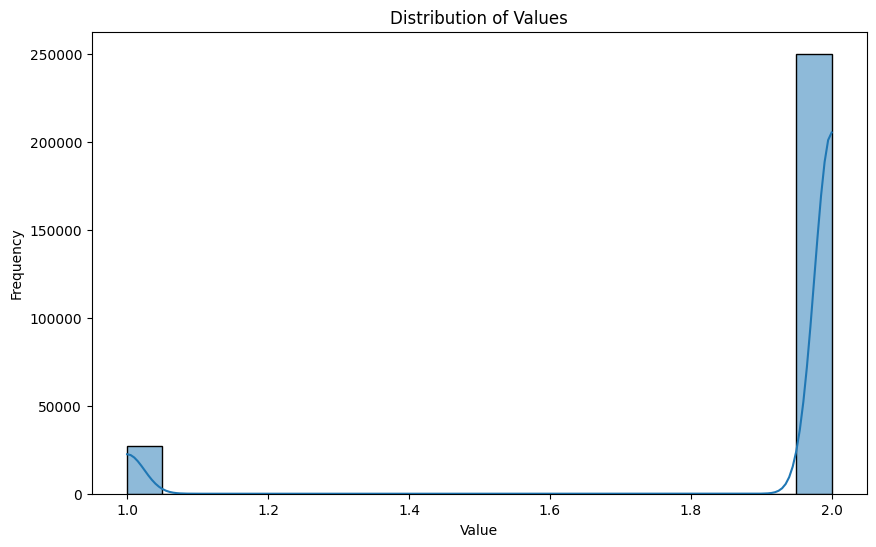

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['k2q31a'], kde=True)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [8]:
null_values_count = df['k2q31a'].isnull().sum()
print(null_values_count)

1881


In [9]:
# Rename target column as 'y'

df = df.rename(columns={'k2q31a':'y'})

In [10]:
# Drop records with target column = NaN

df = df.dropna(subset=['y'])

In [11]:
df.set_index('hhid', inplace=True)

In [12]:
# Drop categories which are not common across evaluated timespan (2016-2022)

columns_to_remove = ['a1_active','a1_deplstat','a1_employed','a2_active','a2_deplstat','a2_employed','ace11','ace12','askquestion','askquestion2','autoimmune','autoimmune_desc','birth_mo','birth_yr','birth_yr_f','blood_screen','bmiclass','bodyimage','bounceaball','concussion','confirminjury','covidarrange','covidcheckups','cystfib_screen','directions','directions2','drawacircle','drawaface','drawaperson','ebtcards','engage_binge','engage_exercise','engage_fast','engage_interest','engage_noeat','engage_picky','engage_pills','engage_purg','engageconcern','evalfasd','everhomeless','eyecare1','eyecare2','eyecare3','eyecare4','fasd','fruit','genetic_screen','grades','groupofobjects','heart_born','height','homeevic','hospitalstay','inq_edu','inq_employ','inq_home','inq_income','inq_resseg','medhistory','missmortgage','mold','nameemotions','oneword','outdoorswkday','outdoorswkend','overweight','pesticide','placeslived','point','readonedigit','recevalfasd','samesound','sc_aian','sc_asian','sc_nhpi','seekcare','sharetoys','simpleaddition','ssi','ssidisability','sugardrink','tellstory','tenure','threewords','twowords','understand','understand2','vape','vegetables','videophone','videophonecovid','visionexamrec','waitforturn','weight']
df = df.drop(columns=columns_to_remove)

In [13]:
# List of columns to replace with their average
columns_to_average = ['fpl_i1', 'fpl_i2', 'fpl_i3', 'fpl_i4', 'fpl_i5', 'fpl_i6']

# Calculate the row-wise average of the selected columns
df['fpl'] = df[columns_to_average].mean(axis=1)


# Drop the temporary 'fpl' column (optional)
df.drop(columns=columns_to_average)

,fipsst,stratum,formtype,totkids_r,hhlanguage,sc_age_years,sc_sex,k2q35a_1_years,momage,k6q41r_still,...,hardwork,countto_r,rhymeword_r,expulsion,a1_grade_i,family,hhsize_i,hhsize_if,cystfib_desc,fpl
hhid,,,,,,,,,,,,,,,,,,,,,
19000001,51,2A,T1,1,1.0,1,2,NaN,27.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.000000
19000002,21,1,T3,1,1.0,15,1,NaN,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.000000
19000003,13,1,T2,1,1.0,6,2,NaN,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.000000
19000006,47,1,T2,3,1.0,10,1,NaN,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.000000
19000010,18,1,T1,3,1.0,0,2,NaN,32.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21299985,55,1,T3,1,1.0,17,1,NaN,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362.000000
21299988,36,1,T2,3,1.0,7,1,NaN,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.833333
21299992,30,1,T2,1,1.0,8,2,NaN,45.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000


In [14]:
# Drop imputation flags, current diagnosed conditions, and ADHD/ADD related columns

columns_to_remove = ['a1_grade_if','a2_if','addtreat','allergies_curr','anyother_curr','arthritis_curr','blood_curr','bullied_r','calmdown','cystfib_curr','diabetes_curr','downsyn_curr','family','fpl_i1','fpl_i2','fpl_i3','fpl_i4','fpl_i5','fpl_i6','fpl_if','genetic_curr','headache_curr','heart_curr','hhcount_if','hhsize_if','k2q30a','k2q30b','k2q30c','k2q31b','k2q31c','k2q31d','k2q32a','k2q32b','k2q32c','k2q33a','k2q33b','k2q33c','k2q34a','k2q34b','k2q34c','k2q35a','k2q35a_1_years','k2q35b','k2q35c','k2q35d','k2q36a','k2q36b','k2q36c','k2q37a','k2q37b','k2q37c','k2q38a','k2q38b','k2q38c','k2q40a','k2q40b','k2q40c','k2q41a','k2q41b','k2q41c','k2q42a','k2q42b','k2q42c','k2q43b','k2q46a','k2q46b','k2q46c','k2q60a','k2q60b','k2q60c','k2q61a','k2q61b','sc_hispanic_r_if','sc_race_r_if','sc_sex_if','subabuse_curr','tenure_if']
df = df.drop(columns=columns_to_remove)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277665 entries, 19000001 to 21300005
Columns: 379 entries, fipsst to fpl
dtypes: float64(356), int16(1), int8(20), object(2)
memory usage: 765.3+ MB


In [16]:
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['stratum', 'formtype'], dtype='object')


In [17]:
# Get unique values in the 'Category' column
unique_values = df['stratum'].unique()

# Display the unique values
print(unique_values)

# Get unique values in the 'Category' column
unique_values = df['stratum'].unique()

# Display the unique values
print(unique_values)

['2A' '1' 1 2]
['2A' '1' 1 2]


In [18]:
df['formtype'] =  df['formtype'].replace({'T1':1,'T2':2,'T3':3})

In [19]:
df['stratum'] =  df['stratum'].replace({'1':1,'2A':2})

In [20]:
for column in df.columns:
    df[column] = df[column].fillna(df[column].median())

In [21]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to normalize all columns
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277665 entries, 19000001 to 21300005
Columns: 379 entries, fipsst to fpl
dtypes: float64(356), int16(1), int64(2), int8(20)
memory usage: 765.3 MB


In [23]:
df.describe()

,fipsst,stratum,formtype,totkids_r,hhlanguage,sc_age_years,sc_sex,momage,k6q41r_still,k6q42r_never,...,temper_r,calmdown_r,hardwork,countto_r,rhymeword_r,expulsion,a1_grade_i,hhsize_i,cystfib_desc,fpl
count,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,...,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000,277665.000000
mean,29.126411,1.066706,2.060818,1.857357,1.108923,9.043128,1.482754,30.228898,1.967493,1.915394,...,3.994241,3.996384,2.995433,3.995484,2.990856,1.996287,2.959246,3.978236,1.000140,287.915945
std,15.765264,0.249513,0.837729,0.868607,0.412306,5.274476,0.499703,5.692293,0.177342,0.278294,...,0.135710,0.155273,0.195535,0.210577,0.214923,0.076834,0.225241,0.363674,0.020527,118.029210
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,18.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,50.000000
25%,16.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,26.000000,2.000000,2.000000,...,4.000000,4.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000,191.333333
50%,30.000000,1.000000,2.000000,2.000000,1.000000,9.000000,1.000000,30.000000,2.000000,2.000000,...,4.000000,4.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000,322.000000
75%,41.000000,1.000000,3.000000,2.000000,1.000000,14.000000,2.000000,34.000000,2.000000,2.000000,...,4.000000,4.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000,400.000000
max,56.000000,2.000000,3.000000,4.000000,3.000000,17.000000,2.000000,45.000000,2.000000,2.000000,...,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,3.000000,5.000000,4.000000,400.000000


In [24]:
corr = df.corr()

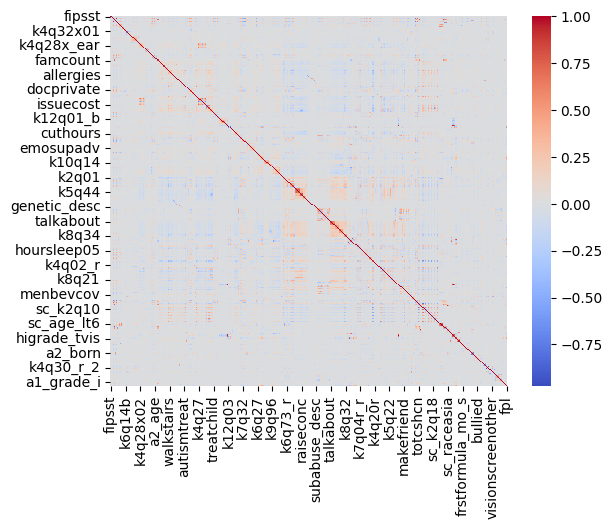

In [25]:
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

In [26]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(df)

In [27]:
print(pca.explained_variance_ratio_)

[9.98956031e-01 9.74048643e-04 2.52386549e-05 1.77890872e-05
 1.00496991e-05 2.51498108e-06 2.36099160e-06 1.73142030e-06
 9.79445108e-07 9.15925301e-07 9.01749514e-07 6.12623440e-07
 4.10289284e-07 3.59083018e-07 3.24914009e-07 2.56596641e-07
 2.51658561e-07 2.34768090e-07 1.93027164e-07 1.84885230e-07
 1.61696058e-07 1.53926310e-07 1.45959517e-07 1.26521601e-07
 1.19710180e-07 1.16371710e-07 1.01453749e-07 9.63662952e-08
 9.06111368e-08 8.89825109e-08 8.30843650e-08 8.13867482e-08
 7.78433190e-08 7.56540729e-08 7.09659203e-08 7.01629729e-08
 6.57186534e-08 6.32347503e-08 6.05105666e-08 5.77036003e-08
 5.56128152e-08 5.39547376e-08 5.32269565e-08 5.07854378e-08
 4.83704414e-08 4.67416698e-08 4.57575916e-08 4.48636983e-08
 4.43771840e-08 4.36698931e-08 4.17819778e-08 4.04047657e-08
 3.98303412e-08 3.84915592e-08 3.60905763e-08 3.57811948e-08
 3.47094851e-08 3.35960132e-08 3.31950170e-08 3.22038253e-08
 3.17652149e-08 3.03166520e-08 2.92615979e-08 2.77099133e-08
 2.64264476e-08 2.608380

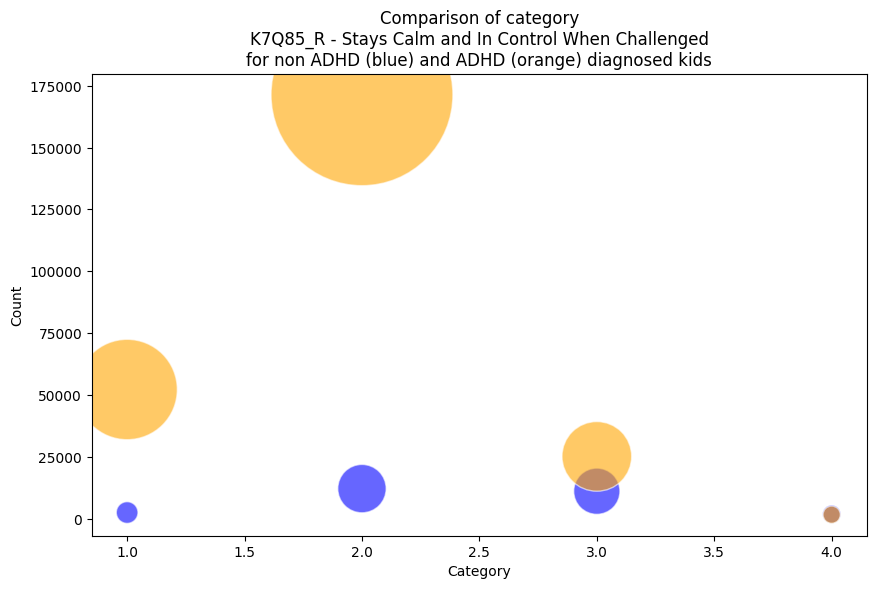

In [28]:
# Count the occurrences of each Category and Type
grouped = df.groupby(['k7q85_r','y']).size().reset_index(name='Count')

# Plot bubble chart
plt.figure(figsize=(10, 6))

# Plot each type with a different color
types = grouped['y'].unique()
colors = ['blue', 'orange']

for t, color in zip(types, colors):
    subset = grouped[grouped['y'] == t]
    plt.scatter(subset['k7q85_r'], subset['Count'],
                s=subset['Count']*0.1,  # Scale size of bubbles
                alpha=0.6, edgecolors="w", label=f'Type {t}', color=color)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Comparison of category\nK7Q85_R ‐ Stays Calm and In Control When Challenged\nfor non ADHD (blue) and ADHD (orange) diagnosed kids')
plt.legend(title="Type")
plt.legend().remove()

# Display the chart
plt.show()

In [29]:
adhd_df = df[df['y'] == 1]
noadhd_df = df[df['y'] == 2]

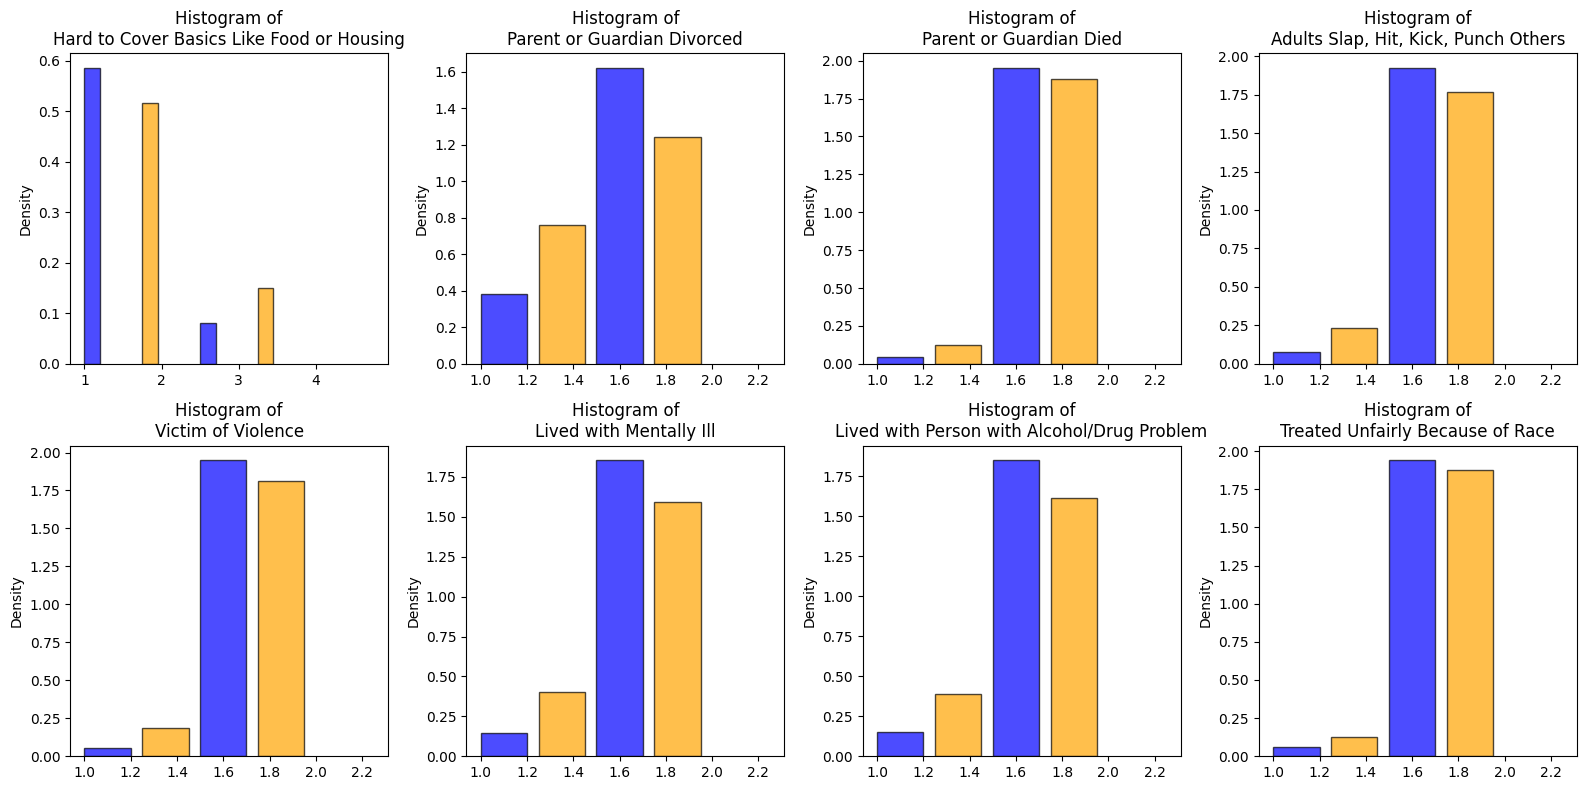

In [30]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()
columns = ['ace1', 'ace3', 'ace4', 'ace6', 'ace7', 'ace8', 'ace9', 'ace10']
columns_labels = ['Hard to Cover Basics Like Food or Housing',
                  'Parent or Guardian Divorced',
                  'Parent or Guardian Died',
                  'Adults Slap, Hit, Kick, Punch Others',
                  'Victim of Violence',
                  'Lived with Mentally Ill',
                  'Lived with Person with Alcohol/Drug Problem',
                  'Treated Unfairly Because of Race']
# Plot histograms in each subplot
for i, column in enumerate(columns):
    noadhd_df[column].plot(kind='hist', bins=2, ax=axes[i], edgecolor='black', alpha=0.7, density=True, color='blue', width=0.2)
    adhd_df[column].plot(kind='hist', bins=2, ax=axes[i], edgecolor='black', alpha=0.7, density=True, color='orange', width=0.2, align='right' )
    axes[i].set_title(f'Histogram of\n{columns_labels[i]}')
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

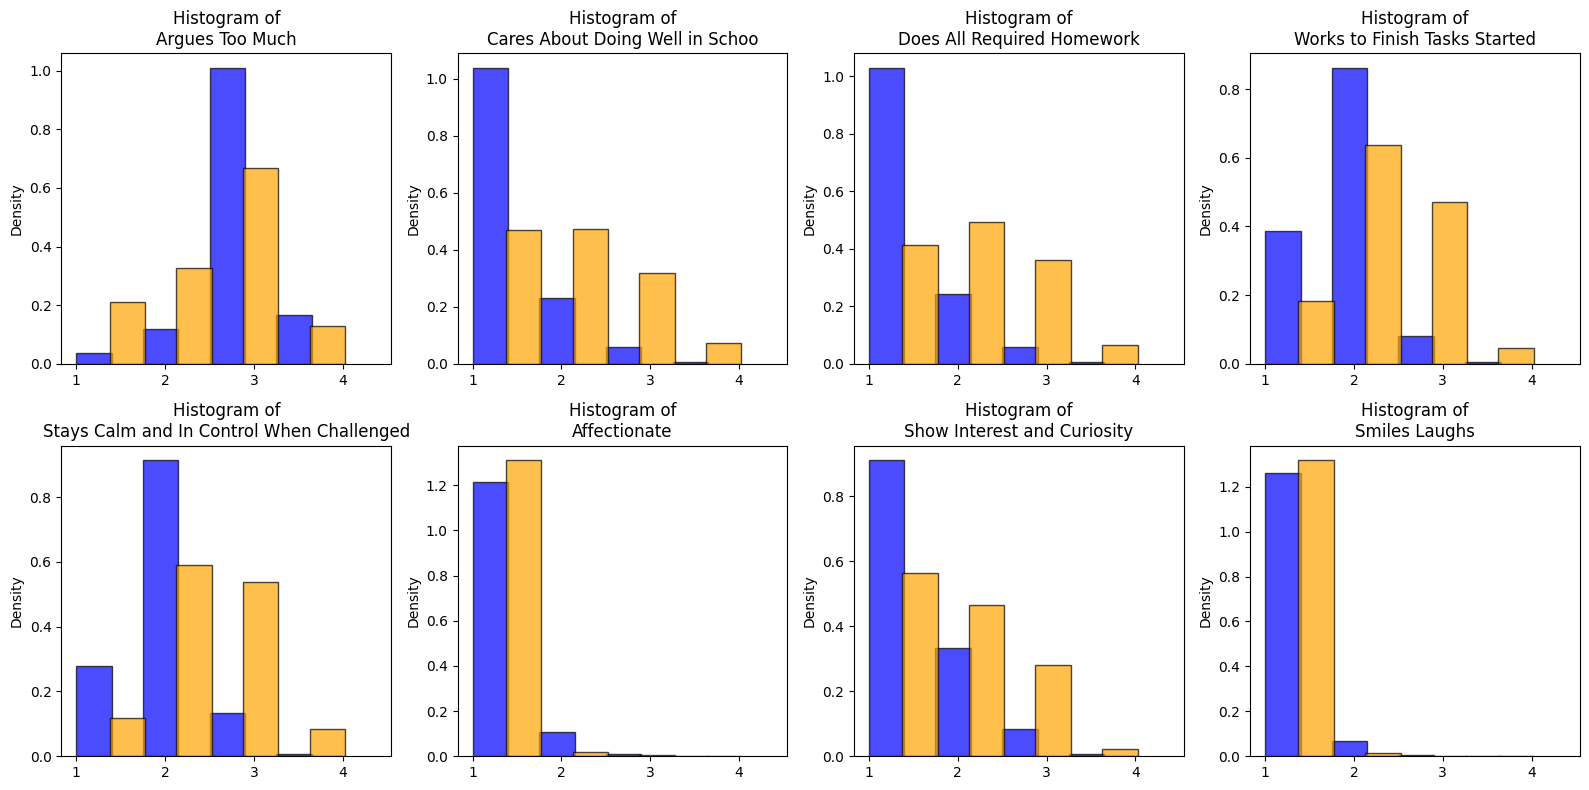

In [31]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()
columns = ['k7q70_r', 'k7q82_r', 'k7q83_r', 'k7q84_r', 'k7q85_r', 'k6q70_r', 'k6q71_r', 'k6q72_r']
columns_labels = ['Argues Too Much',
                  'Cares About Doing Well in Schoo',
                  'Does All Required Homework',
                  'Works to Finish Tasks Started',
                  'Stays Calm and In Control When Challenged',
                  'Affectionate',
                  'Show Interest and Curiosity',
                  'Smiles Laughs']
# Plot histograms in each subplot
for i, column in enumerate(columns):
    noadhd_df[column].plot(kind='hist', bins=4, ax=axes[i], edgecolor='black', alpha=0.7, density=True, color='blue', width=0.4)
    adhd_df[column].plot(kind='hist', bins=4, ax=axes[i], edgecolor='black', alpha=0.7, density=True, color='orange', width=0.4, align='right' )

    axes[i].set_title(f'Histogram of\n{columns_labels[i]}')
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Define the target variable and features
target = 'y'
features = df.drop(columns=[target]).select_dtypes(include=['number']).columns  # Selecting numerical features

X = df[features].sample(frac=0.3, random_state=42)
y = df[target].sample(frac=0.3, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the models and hyperparameters to test in the grid search
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'DecisionTree': DecisionTreeClassifier()
}

params = {
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
    'LogisticRegression': {'C': [0.01, 0.1, 1], 'solver': ['liblinear']},
    'SVM': {'C': [0.1, 1], 'kernel': ['linear', 'rbf']},
    'DecisionTree': {'max_depth': [5, 10], 'min_samples_split': [2, 5]}
}

# Store the results
results = []

# Loop over the models and perform grid search with cross-validation
for model_name, model in models.items():
    grid = GridSearchCV(model, params[model_name], cv=5, scoring='accuracy', n_jobs=-1)

    # Measure execution time
    start_time = time.time()
    grid.fit(X_train, y_train)
    end_time = time.time()

    # Predict on the test set
    y_pred = grid.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Save the results
    results.append({
        'Model': model_name,
        'BestParams': grid.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Execution Time (s)': end_time - start_time,
        'Confusion Matrix': cm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)
